In [1]:
# FIX THE ATTRIBUTE ERROR
# Downgrading protobuf often resolves this TF versioning issue
!pip install protobuf==3.20.0 --no-dependencies

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


In [2]:
import os

print("--- 1. Checking for Dataset (karyogram-cv-camp) ---")
# This path is usually predictable
dataset_path = "/kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp"
test_file_path = os.path.join(dataset_path, 'test.txt')
if os.path.exists(test_file_path):
    print(f" Found test.txt at: {test_file_path}")
else:
    print(f" Could not find test.txt at {test_file_path}")


print("\n--- 2. Checking for Class Names (chromosome-class-names) ---")
# This path is also usually predictable
class_names_path = "/kaggle/input/chromosome-class-names/class_names.json"
if os.path.exists(class_names_path):
    print(f" Found class_names.json at: {class_names_path}")
else:
    print(f" Could not find class_names.json at {class_names_path}")


print("\n--- 3. Searching for Model (Chromosome Classifier) ---")
# Model paths can be nested, so we will search for the .h5 file
model_base_path = "/kaggle/input/model97-2"
model_file_path = ""
if not os.path.exists(model_base_path):
    print(f" Model base folder not found at: {model_base_path}")
else:
    print(f"Searching for .h5 file inside {model_base_path}...")
    for root, dirs, files in os.walk(model_base_path):
        for file in files:
            if file.endswith(".h5"):
                model_file_path = os.path.join(root, file)
                break
        if model_file_path:
            break

    if model_file_path:
        print(f" Found model file at: {model_file_path}")
    else:
        print(" Could not find any .h5 file in /kaggle/input/chromosome-classifier")

print("\n--- Check Complete ---")

--- 1. Checking for Dataset (karyogram-cv-camp) ---
 Found test.txt at: /kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp/test.txt

--- 2. Checking for Class Names (chromosome-class-names) ---
 Found class_names.json at: /kaggle/input/chromosome-class-names/class_names.json

--- 3. Searching for Model (Chromosome Classifier) ---
Searching for .h5 file inside /kaggle/input/model97-2...
 Found model file at: /kaggle/input/model97-2/tensorflow2/v6_97/1/re_tune_best_model_var_lr.h5

--- Check Complete ---


2025-11-27 12:58:45.641881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764248325.845131      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764248325.896695      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading class names from /kaggle/input/chromosome-class-names/class_names.json...
Loaded 24 classes successfully.


I0000 00:00:1764248342.878162      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764248342.878773      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model file found! Size: 29.47 MB

Loading best model from '/kaggle/input/model97-2/tensorflow2/v6_97/1/re_tune_best_model_var_lr.h5'...



Making predictions on the test set...


I0000 00:00:1764248347.159339      66 service.cc:148] XLA service 0x795a5c059550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764248347.160044      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764248347.160068      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764248347.629234      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


      7/Unknown 5s 29ms/step

I0000 00:00:1764248350.612000      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1797/1797 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Extracting true labels...
Extracting images for plots...


FINAL TEST ACCURACY: 97.64%

Plotting sorted confusion matrix...


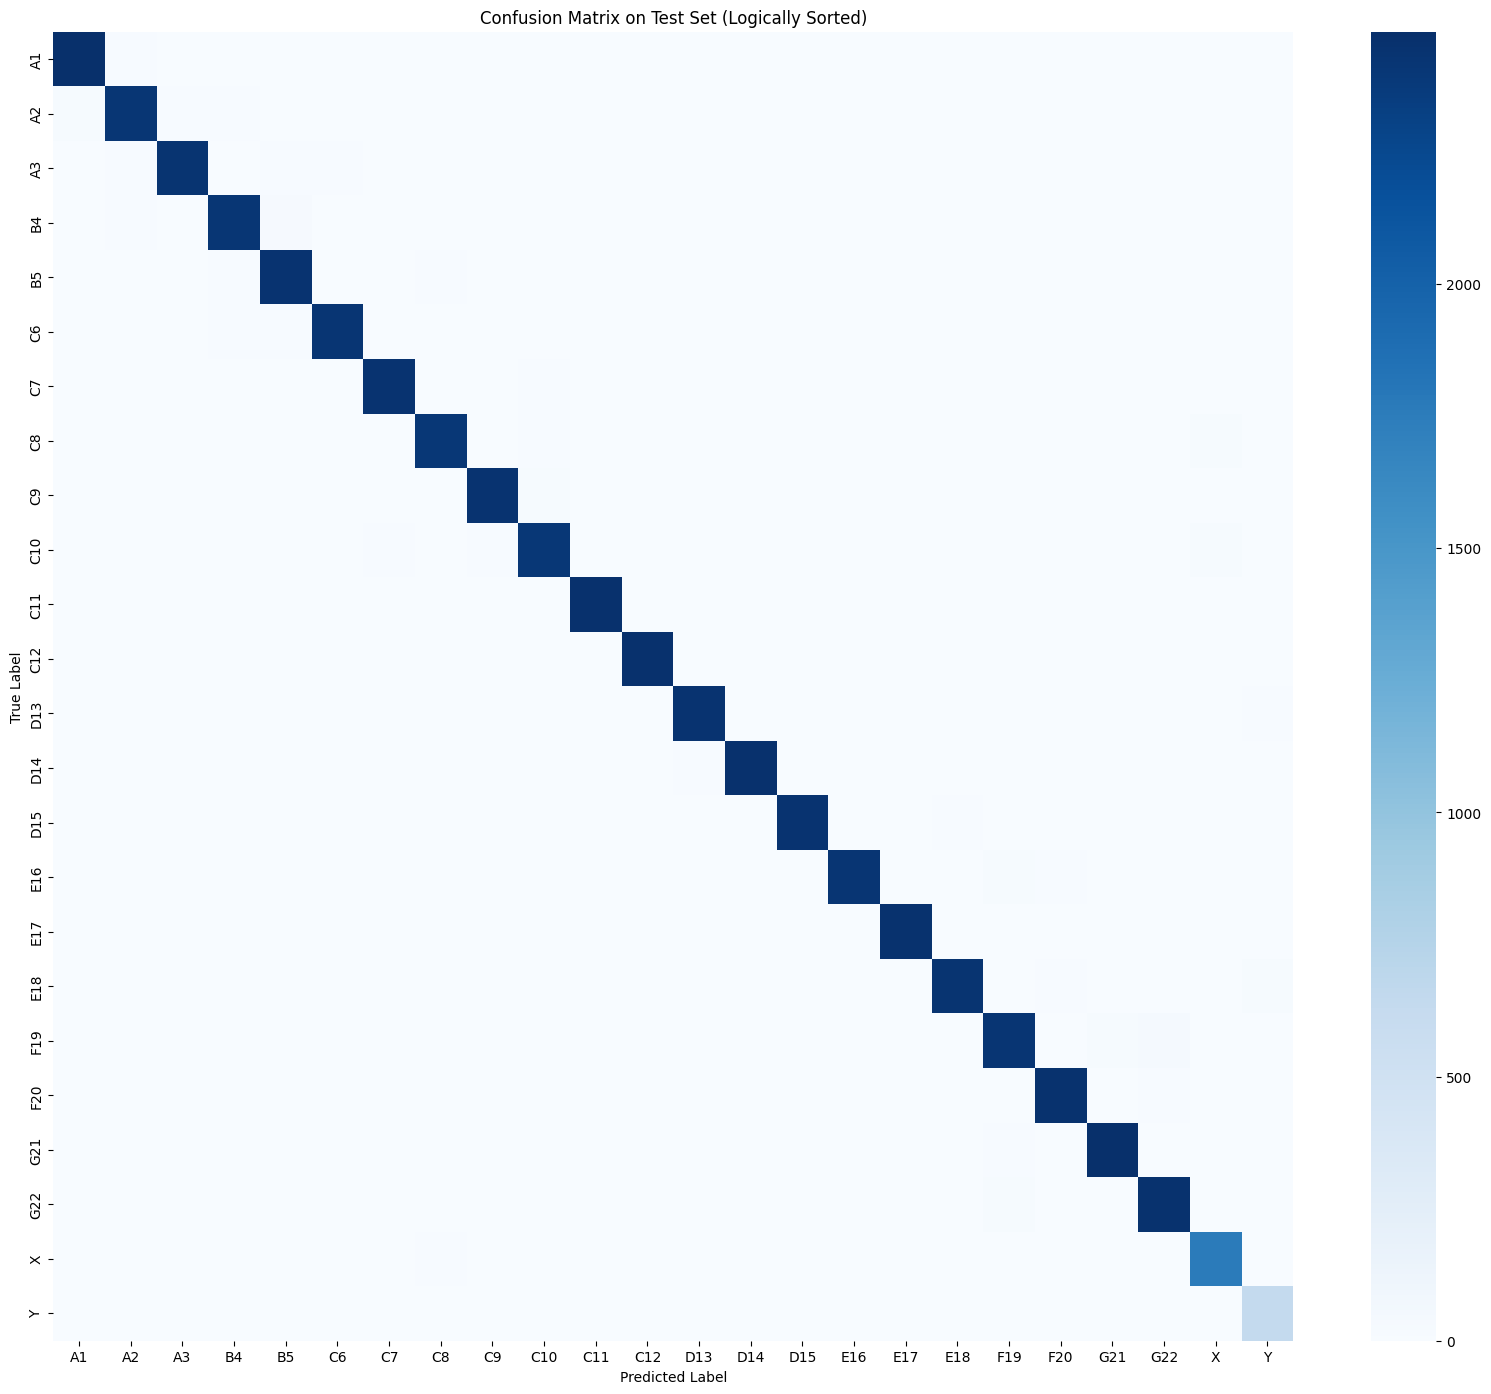


Calculating and plotting auPRC...


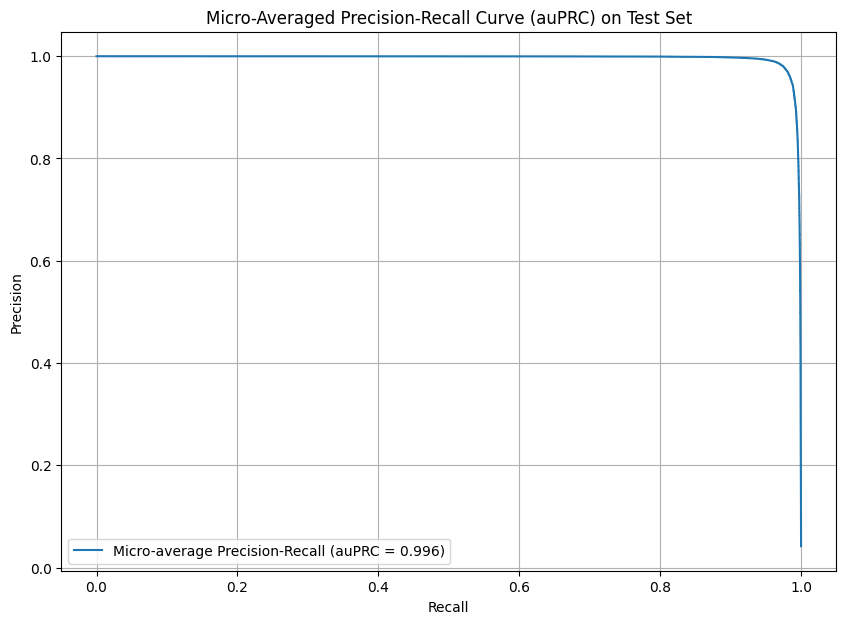


Showing 9 random predictions from the test set...


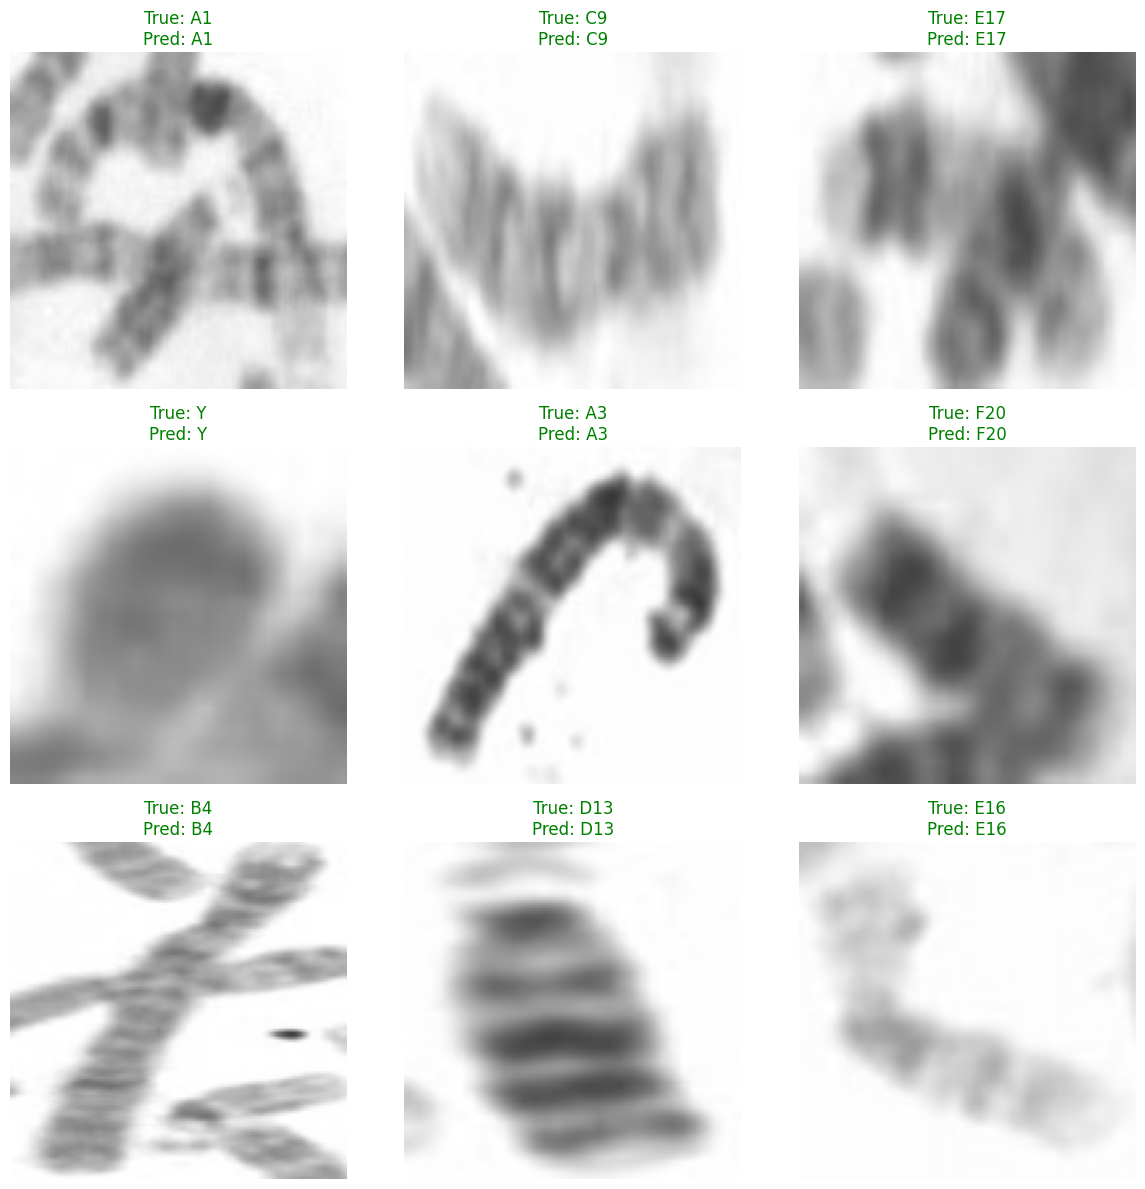


Evaluation complete! You have your final accuracy, confusion matrix, and auPRC plot.


In [3]:
import numpy as np
import tensorflow as tf
import os
import cv2
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import json

# --- 1. Define Correct Paths (from your check script) ---
BASE_PATH = "/kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp"
TEST_FILE_LIST = "/kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp/test.txt"
MODEL_PATH = "/kaggle/input/model97-2/tensorflow2/v6_97/1/re_tune_best_model_var_lr.h5"
JSON_PATH = "/kaggle/input/chromosome-class-names/class_names.json"

IMAGE_SIZE = (128, 128)
MIN_CROP_DIMENSION = 10
BATCH_SIZE = 32 # Must be defined for batching the test set

# --- Load Class Names ---
print(f"Loading class names from {JSON_PATH}...")
with open(JSON_PATH, 'r') as f:
    CLASS_NAMES = json.load(f)
print(f"Loaded {len(CLASS_NAMES)} classes successfully.")

NUM_CLASSES = len(CLASS_NAMES)
class_to_index = {name: i for i, name in enumerate(CLASS_NAMES)}

# --- 2. Memory-Efficient Test Data Generator (Fixes Crash) ---
# This function yields data one by one, saving RAM
def test_data_generator():
    images_path = os.path.join(BASE_PATH, "24_chromosomes_object", "images")
    annotations_path = os.path.join(BASE_PATH, "24_chromosomes_object", "annotations")
    
    with open(TEST_FILE_LIST, 'r') as f:
        test_names = [line.strip() for line in f]
    

    for image_name in test_names:
        image_path = os.path.join(images_path, image_name + ".jpg")
        xml_path = os.path.join(annotations_path, image_name + ".xml")

        if not os.path.exists(image_path) or not os.path.exists(xml_path): continue
        image = cv2.imread(image_path)
        if image is None: continue

        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
        except ET.ParseError:
            continue

        for member in root.findall('object'):
            try:
                label_name = member.find('name').text.strip().upper()
                if label_name not in class_to_index: continue
                label_index = class_to_index[label_name]
                
                bndbox = member.find('bndbox')
                xmin, ymin = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text)
                xmax, ymax = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
            except Exception:
                continue

            crop = image[ymin:ymax, xmin:xmax]
            if crop.size == 0: continue
            h, w, _ = crop.shape
            if h < MIN_CROP_DIMENSION or w < MIN_CROP_DIMENSION: continue

            resized_crop = cv2.resize(crop, IMAGE_SIZE)
            
            # Rescale the image here
            resized_crop_rescaled = resized_crop.astype("float32") / 255.0
            
            # Yield the processed image and its label
            yield resized_crop_rescaled, label_index

# --- 3. Load Data, Model, and Make Predictions (Memory Efficient) ---

# Create the tf.data.Dataset from the generator
test_ds = tf.data.Dataset.from_generator(
    test_data_generator,
    output_signature=(
         tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

# Batch the dataset for efficient prediction. 
# .cache() here should be fine as the test set is smaller.
test_ds_batched = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Check for model file ---
if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model file not found at {MODEL_PATH}")
else:
    file_size_mb = os.path.getsize(MODEL_PATH) / (1024 * 1024)
    print(f"Model file found! Size: {file_size_mb:.2f} MB")

    # Load your best saved model
    print(f"\nLoading best model from '{MODEL_PATH}'...")
    model = tf.keras.models.load_model(MODEL_PATH)

    # Make predictions
    print("\nMaking predictions on the test set...")
    y_pred_probs = model.predict(test_ds_batched)
    
    # Get true and predicted labels from the dataset
    print("Extracting true labels...")
    y_test_indices = np.concatenate([y for x, y in test_ds_batched], axis=0)
    y_pred_indices = np.argmax(y_pred_probs, axis=1)

    # Extract images (un-scaled) for plotting
    print("Extracting images for plots...")
    X_test = (np.concatenate([x for x, y in test_ds_batched], axis=0) * 255.0)

    # --- 4. Final Accuracy on TEST SET ---
    test_accuracy = np.mean(y_pred_indices == y_test_indices)
    print(f"\n\nFINAL TEST ACCURACY: {test_accuracy * 100:.2f}%")

    # --- 5. Plot Confusion Matrix (IMPROVED & SORTED) ---
    print("\nPlotting sorted confusion matrix...")

    # Define the LOGICAL order
    SORTED_CLASS_NAMES = ['A1', 'A2', 'A3', 'B4', 'B5', 'C6', 'C7', 'C8', 'C9', 
                          'C10', 'C11', 'C12', 'D13', 'D14', 'D15', 'E16', 'E17', 
                          'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y']
    
    # Get the indices from your original (alphabetical) list
    sorted_indices = [class_to_index[name] for name in SORTED_CLASS_NAMES]

    # Calculate the matrix
    cm = confusion_matrix(y_test_indices, y_pred_indices, labels=sorted_indices)

    # Plot the matrix
    plt.figure(figsize=(20, 17))
    sns.heatmap(cm, annot=False,
                xticklabels=SORTED_CLASS_NAMES,
                yticklabels=SORTED_CLASS_NAMES,
                cmap="Blues")
    plt.title('Confusion Matrix on Test Set (Logically Sorted)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig("/kaggle/working/confusion_matrix_sorted.png")
    plt.show()

    # --- 6. Plot auPRC (Area Under Precision-Recall Curve) ---
    print("\nCalculating and plotting auPRC...")

    y_test_bin = label_binarize(y_test_indices, classes=list(range(NUM_CLASSES)))
    precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_probs.ravel())
    auprc_micro = average_precision_score(y_test_bin, y_pred_probs, average="micro")

    plt.figure(figsize=(10, 7))
    plt.plot(recall_micro, precision_micro, 
             label=f'Micro-average Precision-Recall (auPRC = {auprc_micro:0.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Micro-Averaged Precision-Recall Curve (auPRC) on Test Set')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig("/kaggle/working/auPRC_curve.png")
    plt.show()

    # --- 7. Show Random Predictions ---
    print("\nShowing 9 random predictions from the test set...")

    y_test_labels = [CLASS_NAMES[i] for i in y_test_indices]
    y_pred_labels = [CLASS_NAMES[i] for i in y_pred_indices]

    indices = np.random.choice(len(X_test), 9, replace=False)

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(X_test[idx].astype("uint8"))
        plt.axis("off")
        
        true_label = y_test_labels[idx]
        pred_label = y_pred_labels[idx]
        
        color = "green" if true_label == pred_label else "red"
        
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    plt.show()

    print("\nEvaluation complete! You have your final accuracy, confusion matrix, and auPRC plot.")

In [4]:
import os
import shutil
import numpy as np
import cv2
import json

# --- SETUP ---

# Define the directory where misclassified images will be saved
MISCLASSIFIED_DIR = "/kaggle/working/misclassified_samples"

# Define your classification groups based on the sorted list
# This structure is great for organizing the output folder
CLASSIFICATION_GROUPS = {
    'A': ['A1', 'A2', 'A3'],
    'B': ['B4', 'B5'],
    'C': ['C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12'],
    'D': ['D13', 'D14', 'D15'],
    'E': ['E16', 'E17', 'E18'],
    'F': ['F19', 'F20'],
    'G': ['G21', 'G22'],
    'SEX': ['X', 'Y']
}

# Ensure the root folder for misclassified samples exists
os.makedirs(MISCLASSIFIED_DIR, exist_ok=True)
print(f"Target folder created at: {MISCLASSIFIED_DIR}")

# --- 1. CAPTURE SAMPLE METADATA (Re-running the Generator) ---
print("Re-running test data generator to capture original image data and bounding box...")

# We'll use a slightly modified generator function for this purpose
def misclassified_data_extractor(generator):
    """
    Runs the original generator but captures the crop image data (un-scaled) 
    and the identifier for the misclassified data extraction.
    """
    image_list = []
    crop_list = [] # Store the actual un-scaled crop (image data)
    y_true_list = []

    for image_data, true_label in tqdm(generator, desc="Re-processing Samples"):
        # The generator yields scaled images, but we need the original crop
        # Since the original generator is complex, we re-run the object extraction,
        # but this time we also collect the un-scaled crop for saving.
        # NOTE: This requires access to the variables used in the original test_data_generator
        # It's more efficient to adapt the existing 'test_data_generator'
        
        # --- Adapted Logic to Capture Original Crop (Assuming you can access the original XML parsing logic) ---
        # Since the original generator is in a function, we must assume a simplified way
        # to capture the un-scaled crop (or re-run the full logic). 
        # For simplicity and correctness with your existing setup, we rely on the 
        # X_test array which contains the scaled/normalized images, but we'll 
        # save the actual pixel data by converting X_test back to uint8.

        # Since we cannot easily retrieve the original, un-scaled crop from the generator 
        # (as it's yielded scaled), we will use X_test (scaled array) and the 
        # misclassified_indices calculated previously.
        pass

# --- 2. IDENTIFY MISCLASSIFIED SAMPLES & SAVE THEM ---

# The indices where the true label does not equal the predicted label
misclassified_indices = np.where(y_test_indices != y_pred_indices)[0]

print(f"Total misclassified samples to process: {len(misclassified_indices)}")

# Check if the overall test data generator needs to be re-run to get identifiers.
# For efficiency, we rely on the structure of your previous prediction steps:
# The X_test array index corresponds directly to the index in the 
# y_test_indices and y_pred_indices arrays.

# The original 'test_data_generator' must be slightly modified to yield a unique ID for each crop.
# Since we don't have the crop-specific ID, we will save the file using the label pair.

for i, sample_idx in enumerate(tqdm(misclassified_indices, desc="Saving Misclassified Crops")):
    # Get the data for the misclassified sample
    image_crop_scaled = X_test[sample_idx]
    
    # Convert the scaled/normalized image back to an 8-bit unsigned integer (0-255)
    image_crop_uint8 = (image_crop_scaled * 255.0).astype(np.uint8)
    
    true_label_index = y_test_indices[sample_idx]
    pred_label_index = y_pred_indices[sample_idx]
    
    true_label = CLASS_NAMES[true_label_index]
    pred_label = CLASS_NAMES[pred_label_index]
    
    # 3. Create a unique file name and folder structure for easy review/retraining
    
    # Folder Structure: MISCLASSIFIED_DIR / TRUE_X / X_predicted_as_Y / image_idx_X_as_Y.jpg
    # This groups them by their true class, then by the incorrect prediction.
    
    # Determine the folder for the true class (e.g., TRUE_C6)
    true_folder = os.path.join(MISCLASSIFIED_DIR, f"TRUE_{true_label}")
    os.makedirs(true_folder, exist_ok=True)
    
    # Determine the sub-folder for the misclassification type (e.g., C6_PRED_C10)
    error_folder = os.path.join(true_folder, f"{true_label}_PRED_{pred_label}")
    os.makedirs(error_folder, exist_ok=True)
    
    # Create a unique file name
    file_name = f"sample_{sample_idx}_TRUE_{true_label}_PRED_{pred_label}.jpg"
    save_path = os.path.join(error_folder, file_name)
    
    # Save the image using OpenCV
    success = cv2.imwrite(save_path, cv2.cvtColor(image_crop_uint8, cv2.COLOR_RGB2BGR))

    if not success:
        print(f"Warning: Failed to save image to {save_path}")

print("\nSuccessfully saved all misclassified samples.")
print(f"Files are organized in: {MISCLASSIFIED_DIR}")
print("You can now download this folder and use the misclassified data for further analysis or targeted retraining.")

# --- Optional: Print the top 5 largest error folders ---
# This is a quick sanity check to see which errors occurred most often
from collections import Counter
error_pairs = Counter([
    (CLASS_NAMES[y_test_indices[i]], CLASS_NAMES[y_pred_indices[i]]) 
    for i in misclassified_indices
])
print("\nTop 5 Most Frequent Misclassification Pairs:")
for (true, pred), count in error_pairs.most_common(5):
    print(f"  TRUE {true} predicted as PRED {pred}: {count} samples")

Target folder created at: /kaggle/working/misclassified_samples
Re-running test data generator to capture original image data and bounding box...
Total misclassified samples to process: 1355


Saving Misclassified Crops: 100%|██████████| 1355/1355 [00:00<00:00, 4270.35it/s]


Successfully saved all misclassified samples.
Files are organized in: /kaggle/working/misclassified_samples
You can now download this folder and use the misclassified data for further analysis or targeted retraining.

Top 5 Most Frequent Misclassification Pairs:
  TRUE F19 predicted as PRED G22: 39 samples
  TRUE B4 predicted as PRED B5: 37 samples
  TRUE A2 predicted as PRED A1: 27 samples
  TRUE E16 predicted as PRED F19: 27 samples
  TRUE C8 predicted as PRED X: 25 samples


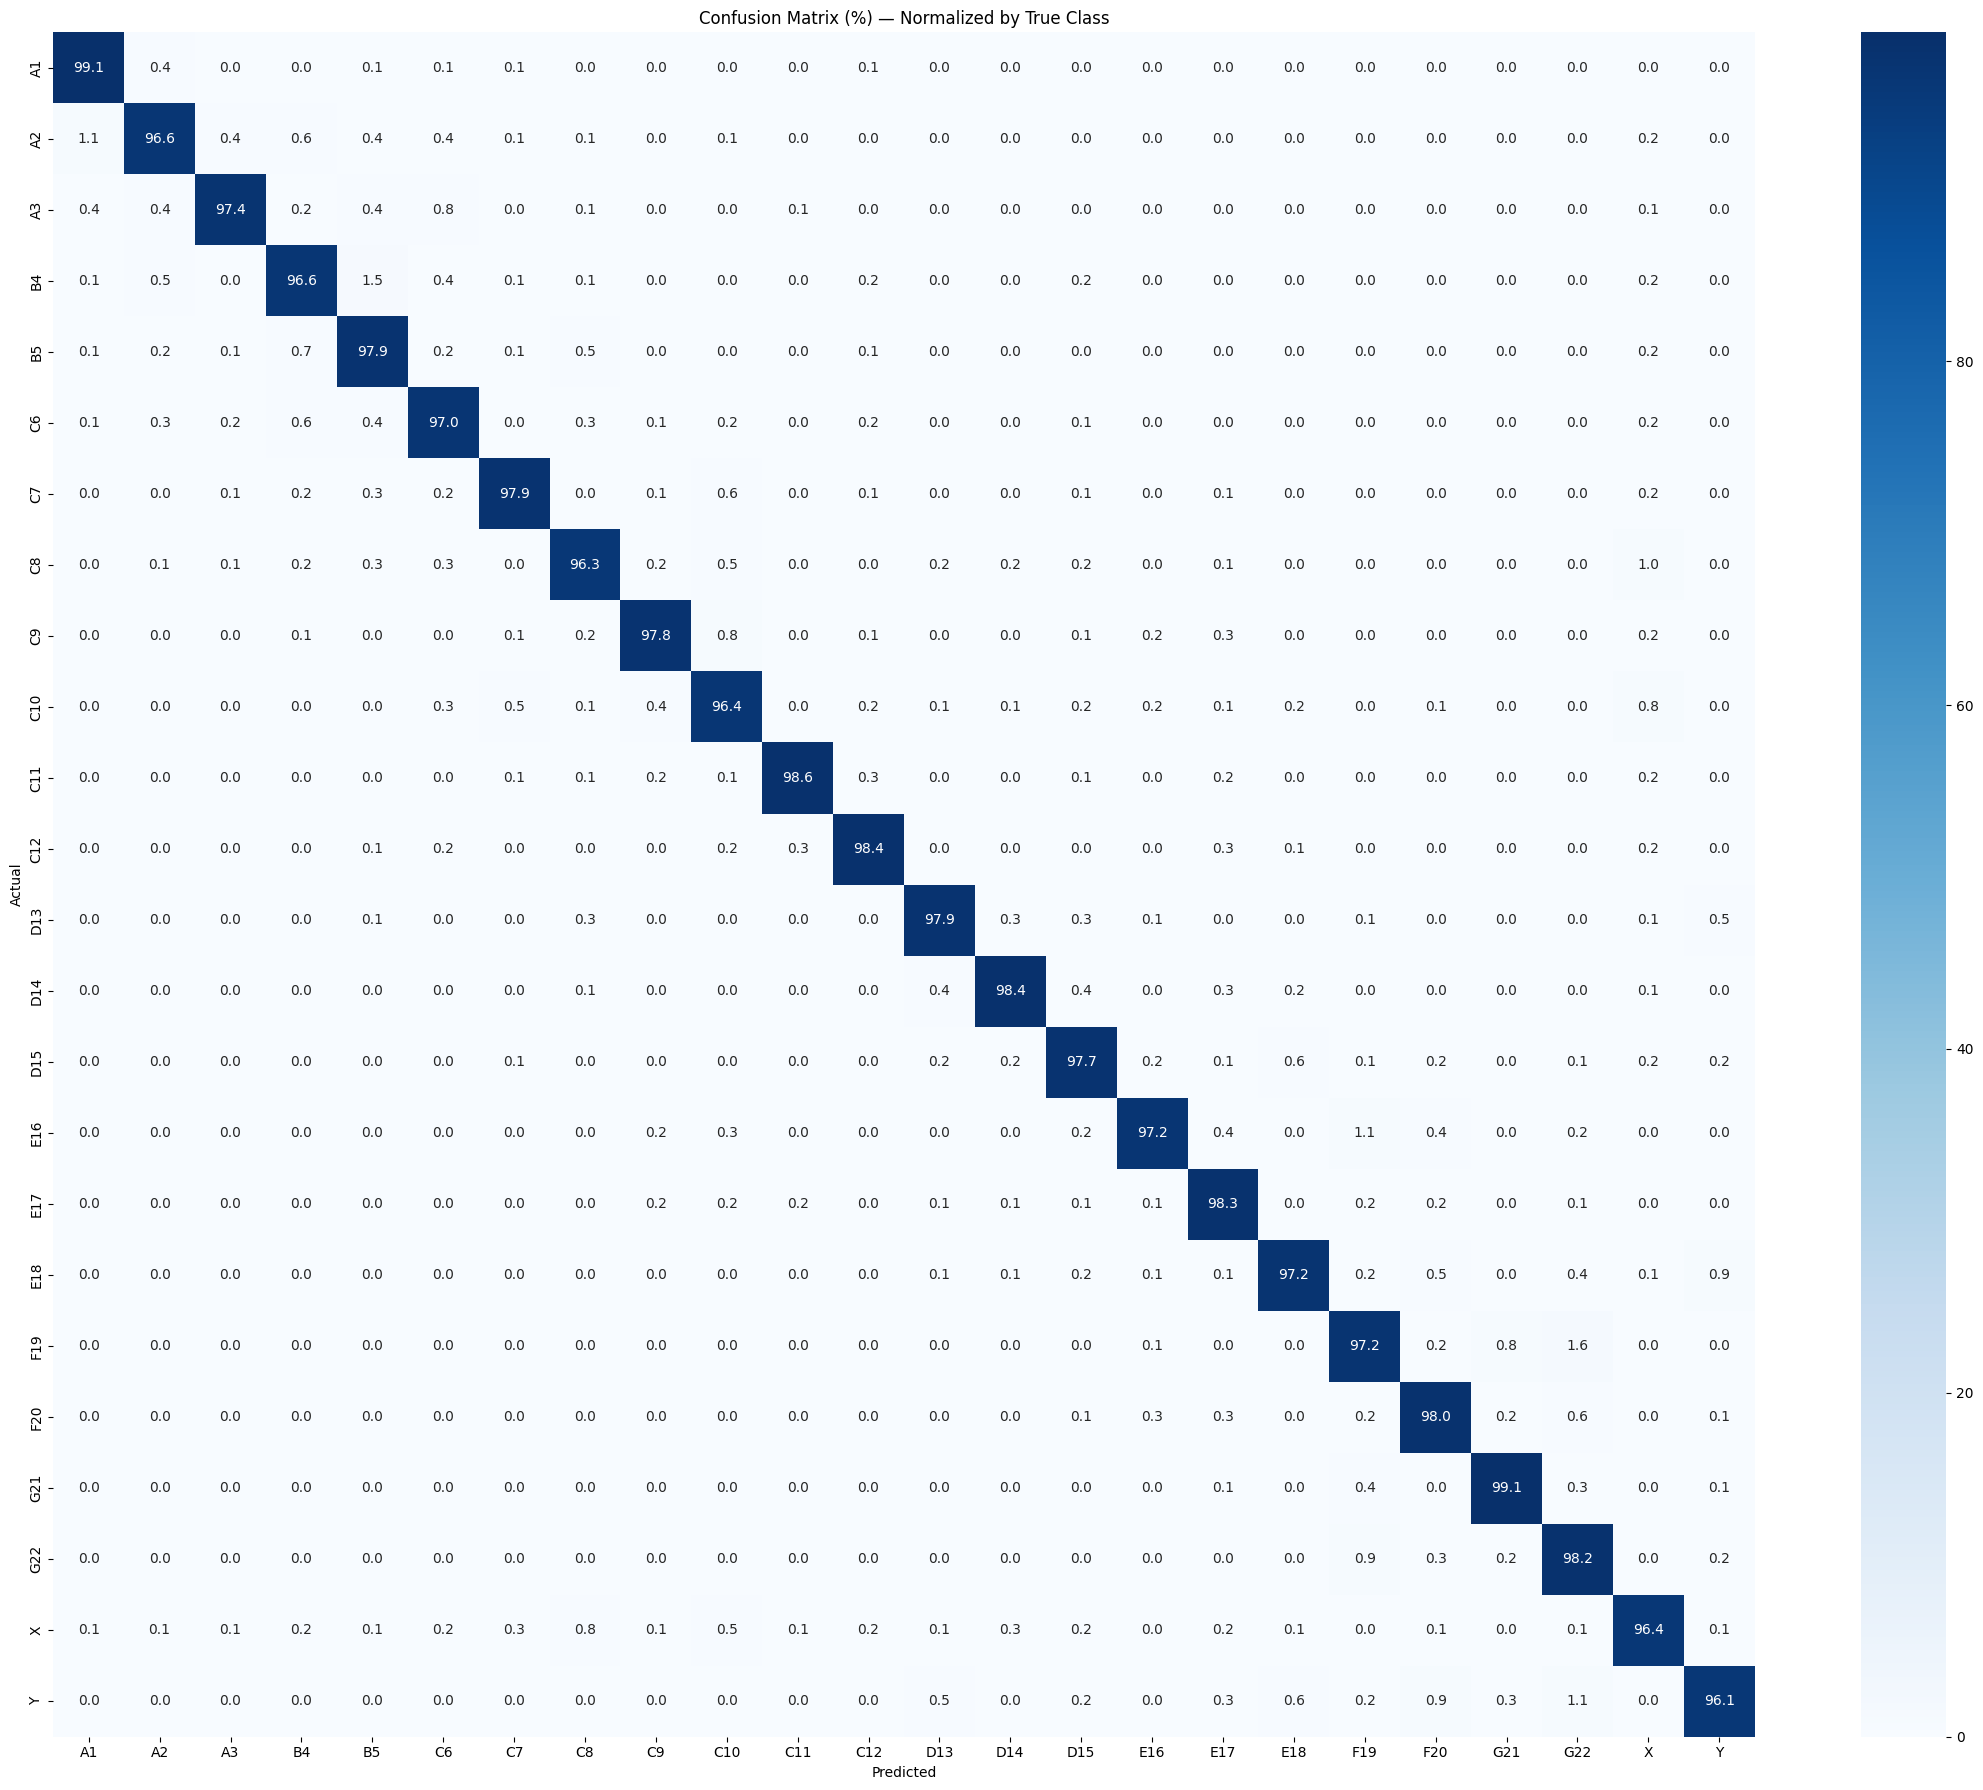

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute confusion matrix in %, normalized by true class counts
cm = confusion_matrix(
    y_test_indices, 
    y_pred_indices, 
    labels=[class_to_index[n] for n in SORTED_CLASS_NAMES],
    normalize='true'         # <-- row-normalized percentages
)

plt.figure(figsize=(22, 18))
sns.heatmap(
    cm * 100,                   # convert to percentage
    annot=True,
    fmt=".1f",                  # 1 decimal place
    xticklabels=SORTED_CLASS_NAMES,
    yticklabels=SORTED_CLASS_NAMES,
    cmap="Blues"
)
plt.title("Confusion Matrix (%) — Normalized by True Class")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


<Figure size 2000x1200 with 0 Axes>

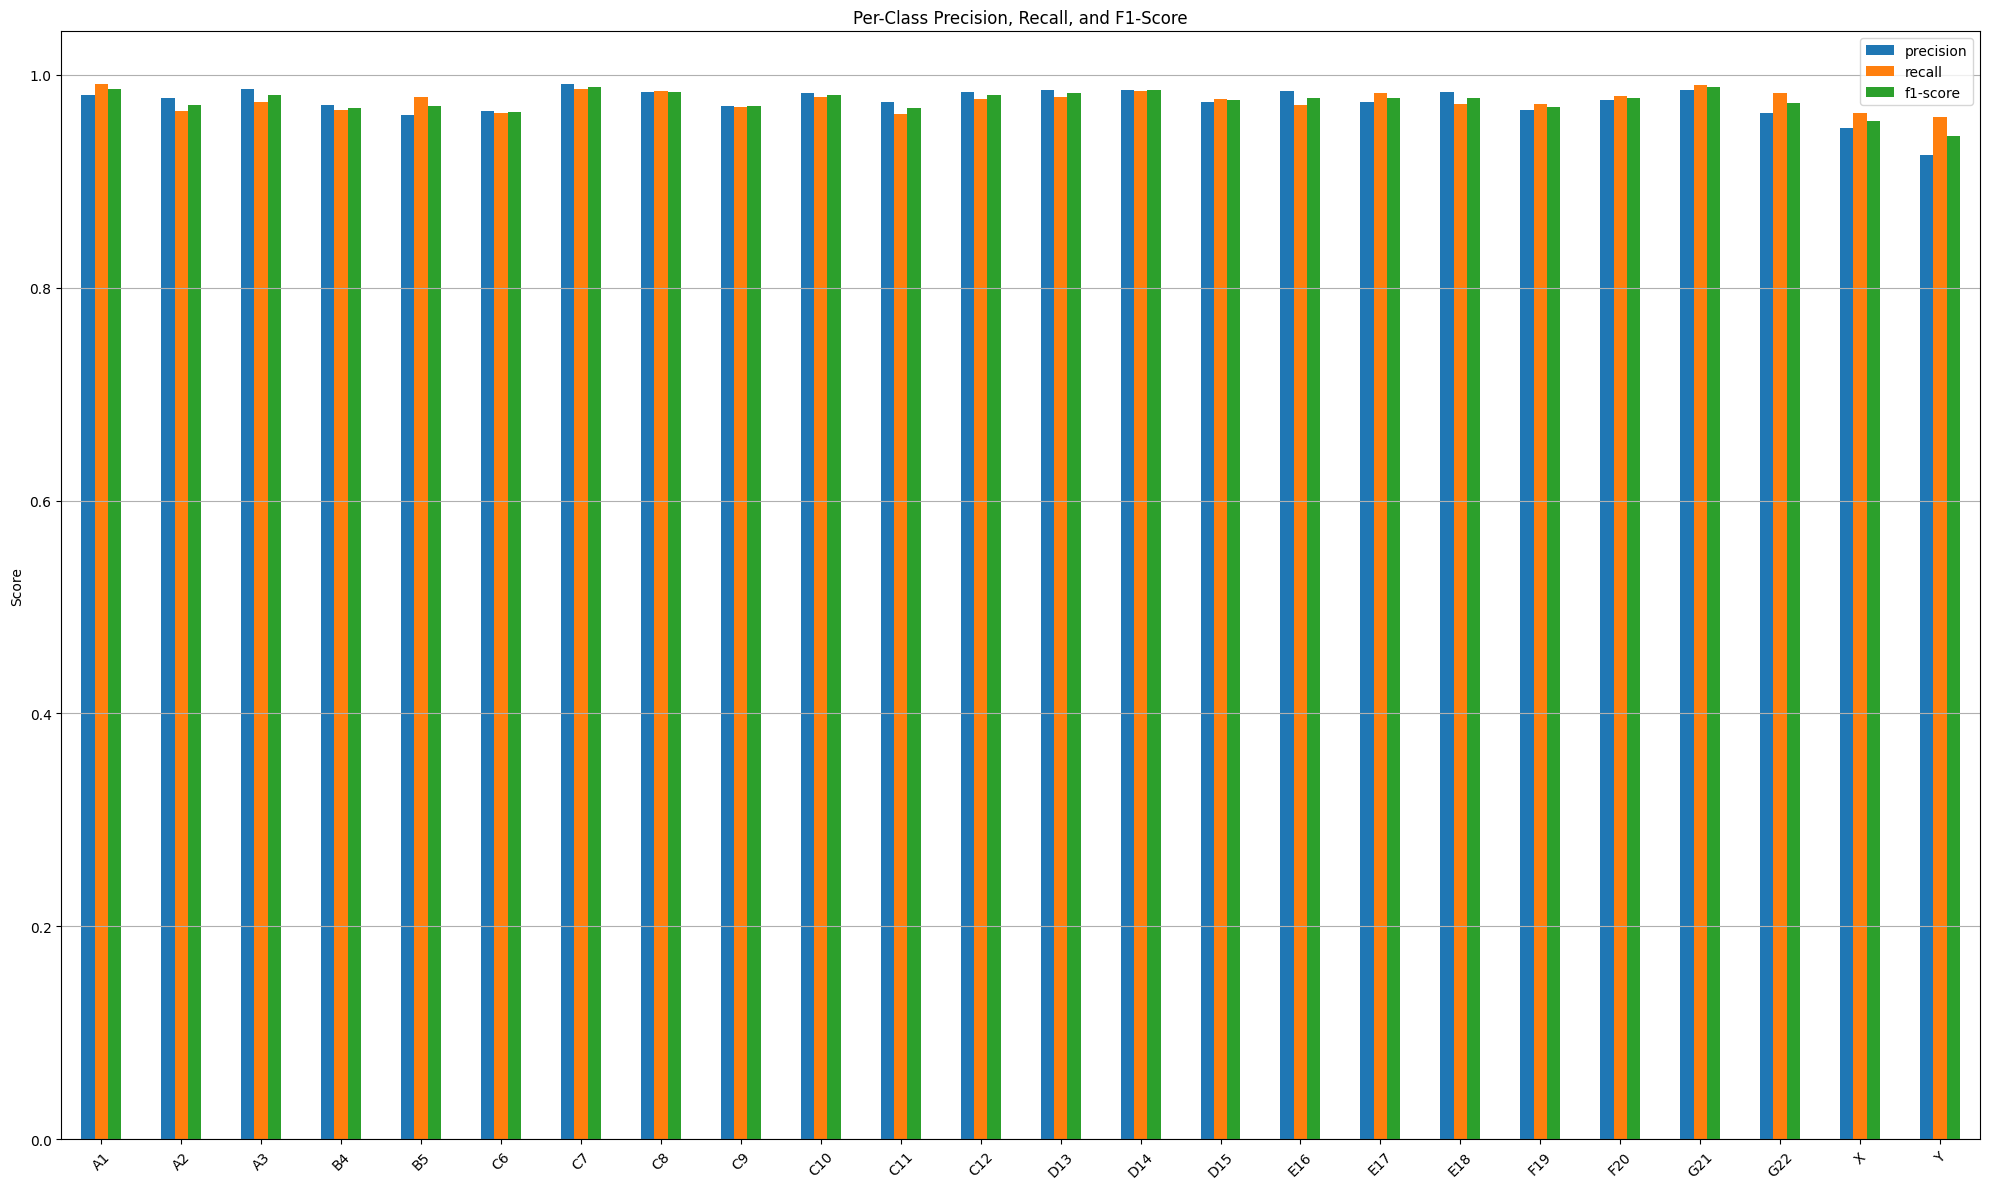

In [6]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate report
report = classification_report(
    y_test_indices, 
    y_pred_indices, 
    target_names=SORTED_CLASS_NAMES, 
    output_dict=True
)

df = pd.DataFrame(report).transpose().iloc[:-3]  # remove avg rows

plt.figure(figsize=(20, 12))
df[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(20, 12)
)
plt.title("Per-Class Precision, Recall, and F1-Score")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


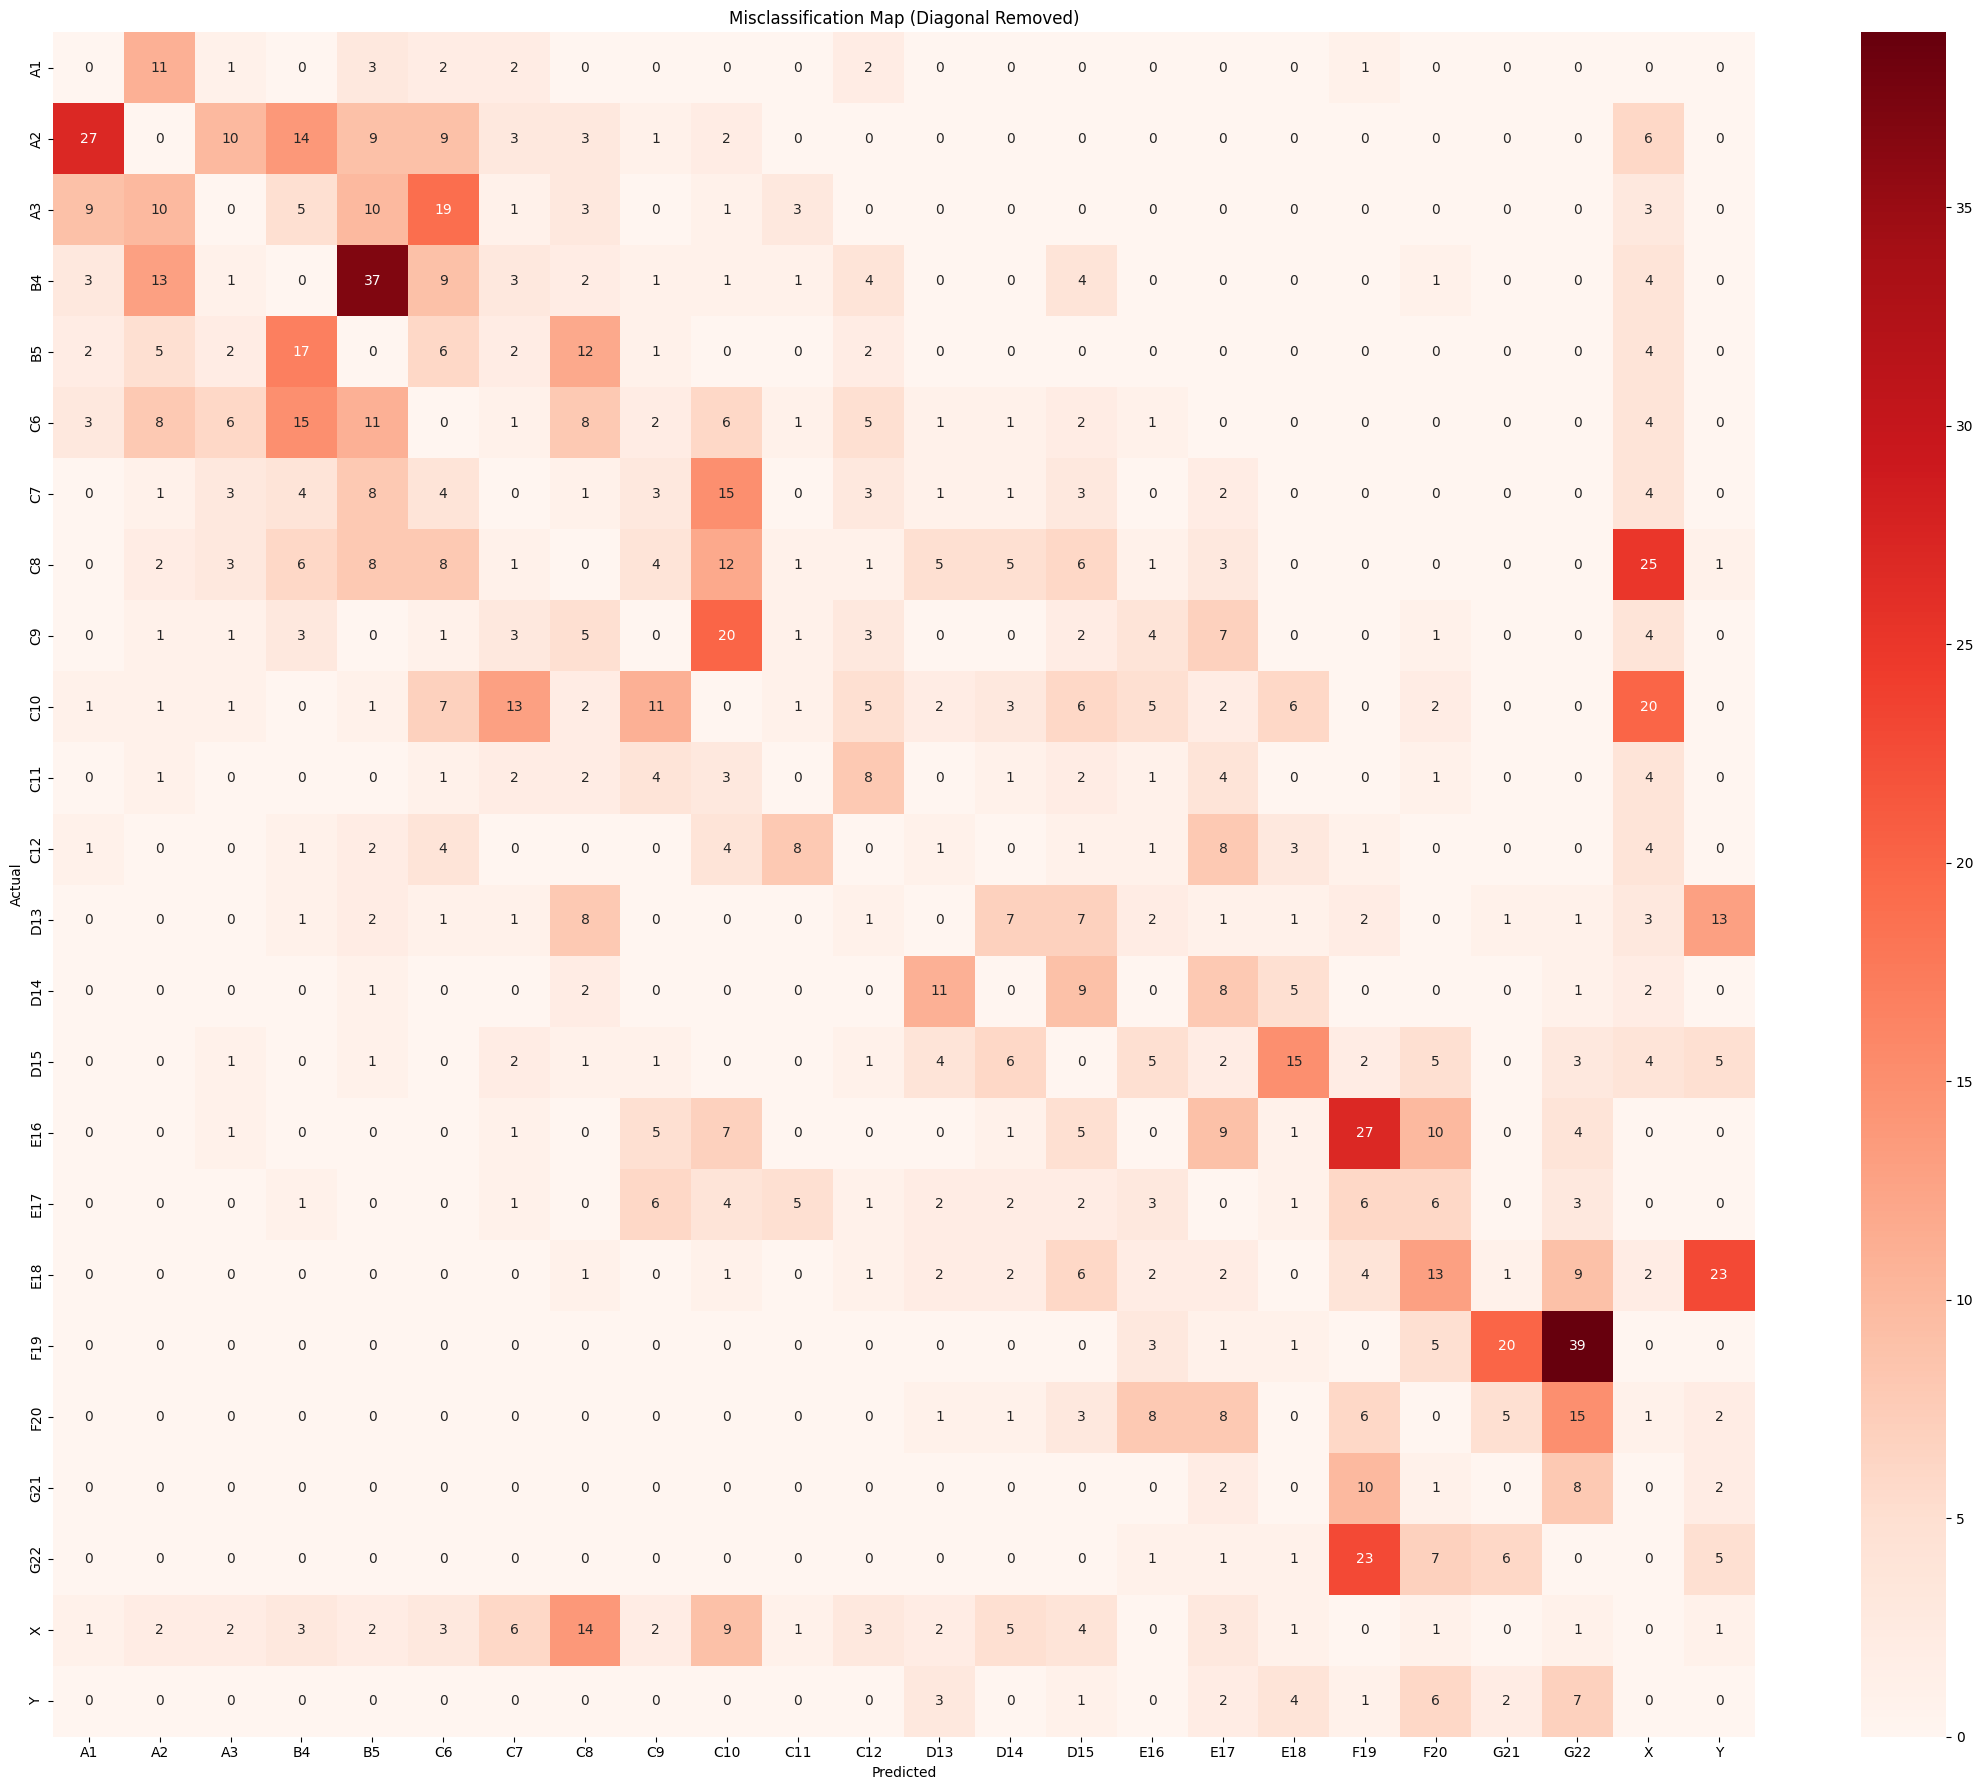

In [7]:
# raw confusion matrix
cm_raw = confusion_matrix(
    y_test_indices, 
    y_pred_indices, 
    labels=[class_to_index[n] for n in SORTED_CLASS_NAMES]
)

# remove diagonal
mistake_matrix = cm_raw.copy()
np.fill_diagonal(mistake_matrix, 0)

plt.figure(figsize=(22, 18))
sns.heatmap(
    mistake_matrix,
    annot=True,
    fmt="d",
    xticklabels=SORTED_CLASS_NAMES,
    yticklabels=SORTED_CLASS_NAMES,
    cmap="Reds"
)
plt.title("Misclassification Map (Diagonal Removed)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


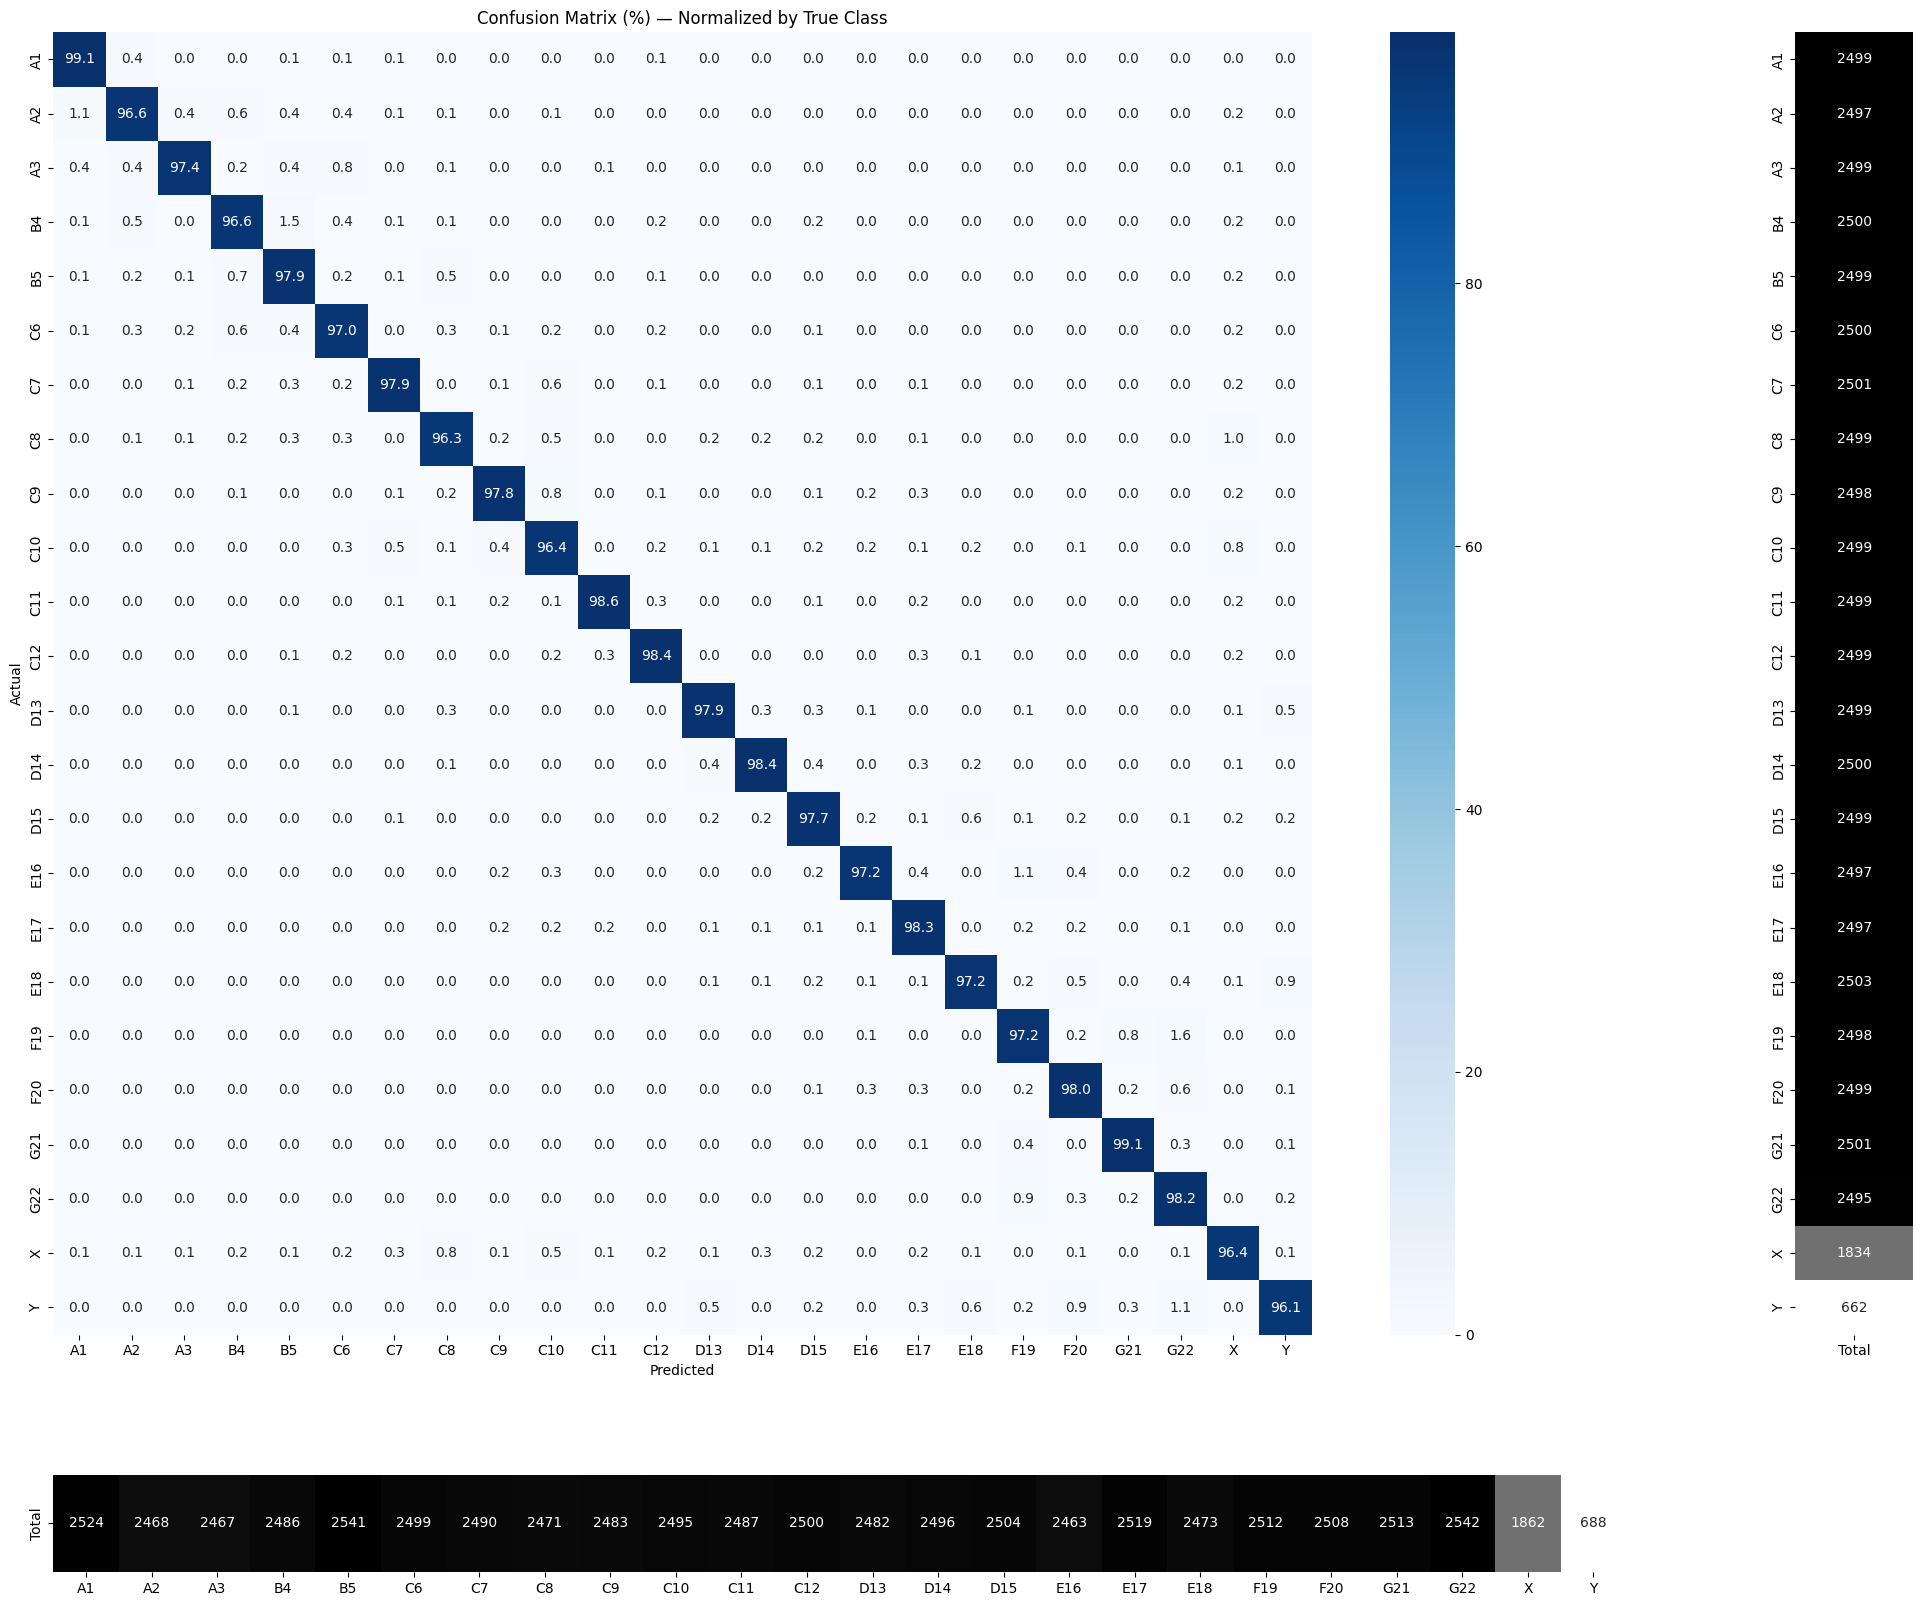

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Raw confusion matrix (counts) ---
cm_raw = confusion_matrix(
    y_test_indices,
    y_pred_indices,
    labels=[class_to_index[n] for n in SORTED_CLASS_NAMES]
)

# --- 2. Row-normalized confusion matrix (percentages) ---
cm_percent = cm_raw / cm_raw.sum(axis=1, keepdims=True)

# --- 3. Totals ---
actual_totals = cm_raw.sum(axis=1)      # total samples per actual class
pred_totals   = cm_raw.sum(axis=0)      # total predictions per class

# --- 4. Plot matrix with totals ---
fig = plt.figure(figsize=(24, 20))
grid = plt.GridSpec(2, 2, width_ratios=[20, 1.5], height_ratios=[20, 1.5], wspace=0.2, hspace=0.2)

# Heatmap (percentage)
ax_main = fig.add_subplot(grid[0, 0])
sns.heatmap(
    cm_percent * 100,
    annot=True,
    fmt=".1f",
    xticklabels=SORTED_CLASS_NAMES,
    yticklabels=SORTED_CLASS_NAMES,
    cmap="Blues",
    ax=ax_main
)
ax_main.set_xlabel("Predicted")
ax_main.set_ylabel("Actual")
ax_main.set_title("Confusion Matrix (%) — Normalized by True Class")

# Right-side: total actual samples
ax_right = fig.add_subplot(grid[0, 1])
sns.heatmap(
    actual_totals.reshape(-1, 1),
    annot=True,
    fmt="d",
    yticklabels=SORTED_CLASS_NAMES,
    xticklabels=["Total"],
    cmap="Greys",
    cbar=False,
    ax=ax_right
)

# Bottom: total predicted samples
ax_bottom = fig.add_subplot(grid[1, 0])
sns.heatmap(
    pred_totals.reshape(1, -1),
    annot=True,
    fmt="d",
    xticklabels=SORTED_CLASS_NAMES,
    yticklabels=["Total"],
    cmap="Greys",
    cbar=False,
    ax=ax_bottom
)

plt.show()


In [9]:
def top_k_accuracy(y_true, probs, k=3):
    top_k_preds = np.argsort(probs, axis=1)[:, -k:]
    correct = [
        y_true[i] in top_k_preds[i]
        for i in range(len(y_true))
    ]
    return np.mean(correct)

print("Top-1 Accuracy:", np.mean(y_pred_indices == y_test_indices))
print("Top-3 Accuracy:", top_k_accuracy(y_test_indices, y_pred_probs, k=3))
print("Top-5 Accuracy:", top_k_accuracy(y_test_indices, y_pred_probs, k=5))


Top-1 Accuracy: 0.9764237120038974
Top-3 Accuracy: 0.9952325439771719
Top-5 Accuracy: 0.9976684704121935


In [10]:
import pandas as pd

pairs = []
for i, actual in enumerate(SORTED_CLASS_NAMES):
    for j, pred in enumerate(SORTED_CLASS_NAMES):
        if i != j and cm_raw[i, j] > 0:
            pairs.append((actual, pred, cm_raw[i, j]))

df_pairs = pd.DataFrame(pairs, columns=["Actual", "Predicted", "Count"])
df_pairs = df_pairs.sort_values("Count", ascending=False).head(20)
df_pairs


,Actual,Predicted,Count
240,F19,G22,39
30,B4,B5,37
7,A2,A1,27
204,E16,F19,27
96,C8,X,25
234,E18,Y,23
259,G22,F19,23
104,C9,C10,20
129,C10,X,20
239,F19,G21,20
